In [1]:
# Jupyter's default tab completion is broken right now;
# this seems to be a workaround until it's fixed, per
# https://github.com/jupyter/notebook/issues/3763#issuecomment-745701270
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [2]:
from copy import deepcopy
from datetime import datetime
from itertools import cycle, islice, product
from pathlib import Path
import networkx as nx

import numpy as np
import pandas as pd
import pyphi
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display

import compute
import utils
from utils import substate
from model import Model, Params
import dynamics
import connectedness
import causalchains as cc

In [3]:
def simulate(tpm, initial_state, timesteps):
    """Simulate the dynamics of a system.
    Generates a sequence of states using the TPM and a random number generator.
    Arguments:
        tpm (np.ndarray): TPM to simulate.
        initial_state (int): The initial state of the simulation.
        timesteps (int): The number of timesteps to simulate.
        rng (np.random.Generator): The random number generator to use.
    Returns:
        list: a list of (decimally-indexed) states.
    """
    if not (len(tpm) == len(tpm[0])):
        tpm = pyphi.convert.sbn2sbs(tpm)

    # Get the conditional cumulative distributions
    cumulative_tpm = np.cumsum(tpm, axis=1)
    # We include the initial state so there are ``timesteps`` total in the
    # output
    timesteps = int(timesteps - 1)
    # Get a random draw for each timestep
    draws = np.random.rand(timesteps)
    # Initialize the state trajectory
    path = [initial_state]
    for draw in draws:
        # The next state is the first one whose cumulative probability beats
        # the random draw
        path.append(
            next(
                state
                for state, cumulative_probability in enumerate(cumulative_tpm[path[-1]])
                if cumulative_probability > draw
            )
        )
    return [pyphi.convert.le_index2state(p, int(np.log2(len(tpm)))) for p in path]


def valid_cause_chain(chain, source_subset, sink_subset):
    valid_sink = all([element in sink_subset for element in chain[0][0]])
    valid_source = all([element in source_subset for element in chain[-1][1]])
    return valid_source and valid_sink


def valid_effect_chain(chain, source_subset, sink_subset):
    valid_sink = all([element in sink_subset for element in chain[-1][1]])
    valid_source = all([element in source_subset for element in chain[0][0]])
    return valid_source and valid_sink


def filter_cause_chains(cause_chains, partition):
    if type(partition) is tuple:
        valid_chains = list(
            filter(
                lambda chain: valid_cause_chain(chain, partition[0], partition[1]),
                cause_chains,
            )
        )

    else:
        valid_chains = []
        for part in partition:
            valid_chains.extend(
                list(
                    filter(
                        lambda chain: valid_cause_chain(chain, part[0], part[1]),
                        cause_chains,
                    )
                )
            )
    return valid_chains


def filter_effect_chains(effect_chains, partition):
    if type(partition) is tuple:
        valid_chains = list(
            filter(
                lambda chain: valid_effect_chain(chain, partition[0], partition[1]),
                effect_chains,
            )
        )

    else:
        valid_chains = []
        for part in partition:
            valid_chains.extend(
                list(
                    filter(
                        lambda chain: valid_effect_chain(chain, part[0], part[1]),
                        effect_chains,
                    )
                )
            )
    return valid_chains


def get_connectedness_of_partitioned_bundles(
    cause_chains, effect_chains, source_nodes, sink_nodes
):
    # The connectedness of a partitioned bundle is the sum of connectedness of all its parts.
    get_process_irreducibility(cause_chains, effect_chains, source, sink, k=3)
    return {
        partition: get_subprocess(cause_chains, effect_chains, partition)[
            "connectedness"
        ]
        for partition in list(
            pyphi.partition.mip_bipartitions(source_nodes, sink_nodes)
        )
    }


# NOTE: this should probably be a directed sum of connectedness, to mirror the bigPhi computation


def get_subprocess(cause_chains, effect_chains, partition):
    # from a set cause_chains and effect_chains defined in a whole network

    # we start by filtering the cause and effect chains such that only those chains that diverge from the source_nodes and converge on sink_nodes remain
    cause_bundle = cc.get_bundled_chains(filter_cause_chains(cause_chains, partition))
    effect_bundle = cc.get_bundled_chains(
        filter_effect_chains(effect_chains, partition)
    )

    # then, we compute the subprocess' connectedness by summing the bundle strength of the remaining cause and effect chains.
    connectedness = sum(
        [cc.get_bundle_strength(cause_bundle), cc.get_bundle_strength(effect_bundle)]
    )

    # finally, we return the process with its causal bundles and its total connectedness
    return {
        "causes": cause_bundle,
        "effects": effect_bundle,
        "connectedness": connectedness,
    }


def get_process_account(
    cause_chains,
    effect_chains,
    source_nodes,
    sink_nodes,
    return_process=False,
    old_irreducibility=False,
    hold_process=False
):

    # first, we get the causal chains whose effects start in the source_nodes, and whose causes converge on the sink_nodes
    process = get_subprocess(cause_chains, effect_chains, (source_nodes, sink_nodes))

    if return_process:
        return process

    if not old_irreducibility:
        informativeness, MIP = get_bundle_informativeness(
            cause_chains, effect_chains, source_nodes, sink_nodes, process=process
        )
        selectivity = get_bundle_selectivity(process)
        
        return {
            "process": 'hidden' if hold_process else process,
            "source": source_nodes, 
            "sink": sink_nodes,
            "connectedness": process["connectedness"],
            "informativeness": informativeness,
            "selectivity": selectivity,
            "irreducibility": informativeness*selectivity,
            "MIP": MIP,
        }

    else:
        # next, we the connectedness for every partitioned bundle of causal chains
        partitioned_connectedness = get_connectedness_of_partitioned_bundles(
            cause_chains, effect_chains, source_nodes, sink_nodes
        )

        # We then pick the MIP defined as the one that maximizes the parts' total connectedness is maximized
        MIP = max(partitioned_connectedness, key=partitioned_connectedness.get)

        # we return the process, its MIP, and its irreducibility
        # "process": process,
        return {
            "endpoints": (source_nodes, sink_nodes),
            "MIP": MIP,
            "irreducibility": process["connectedness"] - partitioned_connectedness[MIP],
        }


from pyphi.partition import partition_types


@partition_types.register("bipartition_nonempty")
def bipartition_nonempty(seq):
    """Return a list of non empty bipartitions for a sequence.

    Args:
        a (Iterable): The sequence to partition.

    Returns:
        list[tuple[tuple]]: A list of tuples containing each of the two
        partitions.

    Example:
        >>> bipartition((1,2,3))
        [((1,), (2, 3)), ((2,), (1, 3)), ((1, 2), (3,))]
    """
    partitions = []
    for part0_idx, part1_idx in pyphi.partition.bipartition_indices(len(seq)):
        if len(part0_idx) == 0:
            partitions.append((tuple(seq[i] for i in part1_idx),))
        elif len(part1_idx) == 0:
            partitions.append((tuple(seq[i] for i in part0_idx),))
        else:
            partitions.append(
                (tuple(seq[i] for i in part0_idx), tuple(seq[j] for j in part1_idx))
            )

    return partitions


@partition_types.register("k_partition_nonempty")
def k_partition_nonempty(seq, k):
    """Return a list of non empty k-partitions for a sequence.

    Args:
        seq (Iterable): The sequence to partition.
        k (int): max number of partitions

    Returns:
        list[tuple[tuple]]: A list of tuples containing each of the two
        partitions.

    Example:
        >>> k_partition_nonempty((1,2,3), 2)
        [((1,), (2, 3)), ((2,), (1, 3)), ((1, 2), (3,))]
    """
    return [part for part in list(pyphi.partition.partitions(seq)) if len(part) < k + 1]


def part_to_part_cause_chains(cause_chains, source_parts, sink_parts):
    # filtering cause chains based on the defined parts of source and sinks
    valid_cause_chains = list(
        filter(
            lambda chain: (
                (chain[0][0] in sink_parts) and (chain[-1][1] in source_parts)
            ),
            cause_chains,
        )
    )

    return valid_cause_chains


def part_to_part_effect_chains(effect_chains, source_parts, sink_parts):
    # filtering effect chains based on the defined parts of source and sinks
    valid_effect_chains = list(
        filter(
            lambda chain: (
                (chain[0][0] in source_parts) and (chain[-1][1] in sink_parts)
            ),
            effect_chains,
        )
    )

    return valid_effect_chains


def get_part_to_part_connectedness(
    cause_chains,
    effect_chains,
    source,
    sink,
    source_subset,
    sink_subset,
    only_subsets=False,
):

    # defining the parts of the source and sink defined by the source_subset and sink_subset
    source_parts = [
        subset
        for subset in pyphi.utils.powerset(source, nonempty=True)
        if any([element in source_subset for element in subset])
    ]
    sink_parts = [
        subset
        for subset in pyphi.utils.powerset(sink, nonempty=True)
        if any([element in sink_subset for element in subset])
    ]

    # getting the connectedness of the calid chains
    valid_cause_chains = part_to_part_cause_chains(
        cause_chains, source_parts, sink_parts
    )
    valid_effect_chains = part_to_part_effect_chains(
        effect_chains, source_parts, sink_parts
    )

    cause_bundle = cc.get_bundled_chains(valid_cause_chains)
    effect_bundle = cc.get_bundled_chains(valid_effect_chains)

    connectedness = [cc.get_bundle_strength(cause_bundle), cc.get_bundle_strength(effect_bundle)]
    return {
        'valid_cause_chains': valid_cause_chains,
        'valid_effect_chains': valid_effect_chains,
        "causes": cause_bundle,
        "effects": effect_bundle,
        "connectedness": connectedness,
    }

def get_bundle_informativeness(
    cause_chains, effect_chains, source, sink, process=None
):

    """
    Defining process informativeness in a way inspired by system informativeness. 
    The process is irreducible if there is no bipartition source and sink such that 
    both parths of the source have effects on both parts of the sink, and that 
    both parts of the sink have causes in both parts of the source.
    """
    if process==None:
        process = get_subprocess(cause_chains, effect_chains, (source, sink))
        
    
    if (len(source)==1 and len(sink)==1):
        return  process["connectedness"], (source, sink)

    informativeness = np.inf
    MIP = []
    k = 2

    for source_partition, sink_partition in product(
        list(pyphi.partition.partition_types['k_partition_nonempty'](source, k)), #
        list(pyphi.partition.partition_types['k_partition_nonempty'](sink, k)), #
    ):

        if (len(source_partition)>1 or len(sink_partition)>1):
            part2part = np.array(
                [
                    get_part_to_part_connectedness(
                        cause_chains,
                        effect_chains,
                        source,
                        sink,
                        source_part,
                        sink_part,
                        only_subsets=False,
                    )["connectedness"]
                    for source_part, sink_part in product(source_partition, sink_partition)
                ]
            )
            minimum_part_to_part_connectedness = np.sum(np.min(part2part, axis=0))
            '''touched_effects = []
            touced_causes = []
            for source_part, sink_part in product(source_partition, sink_partition):
                aux = get_part_to_part_connectedness(
                        cause_chains,
                        effect_chains,
                        source,
                        sink,
                        source_part,
                        sink_part,
                        only_subsets=False,
                    )
                touched_effects.extend(aux['valid_cause_chains'])
                touced_causes.extend(aux['valid_effect_chains'])

            minimum_part_to_part_connectedness = sum([cc.get_bundle_strength(cc.get_bundled_chains(touched_effects)),cc.get_bundle_strength(cc.get_bundled_chains(touced_causes)),])'''
            
            
            if minimum_part_to_part_connectedness == informativeness:
                MIP.append((source_partition, sink_partition))
            
            elif minimum_part_to_part_connectedness < informativeness:
                informativeness = minimum_part_to_part_connectedness + 0
                MIP = [(source_partition, sink_partition)]

    return informativeness, MIP

def get_bundle_selectivity(process):
    max_causeeffects = sum(
        [
            min([sum([len(link[1]) for link in bundle]) for bundle in process["causes"]]),
            min([sum([len(link[1]) for link in bundle]) for bundle in process["effects"]]),
        ]
    )
    actual_causeeffects = sum(
        [
            min([sum([link[2] for link in bundle]) for bundle in process["causes"]]),
            min([sum([link[2] for link in bundle]) for bundle in process["effects"]]),
        ]
    )
    return actual_causeeffects/max_causeeffects

    

def get_process_irreducibility_old(
    cause_chains, effect_chains, source, sink, k=3, only_subsets=True
):

    """
    Defining process irreducibility in a way inspired by system irreducibility. 
    The process is irreducible if there is no bipartition source and sink such that 
    both parths of the source have effects on both parts of the sink, and that 
    both parts of the sink have causes in both parts of the source.
    """
    connectedness = get_subprocess(cause_chains, effect_chains, (source, sink))[
        "connectedness"
    ]
    if len(source)==1 and len(sink)==1:
        return {
        "source": source,
        "sink": sink,
        "connectedness": connectedness,
        "irreducibility": connectedness,
        "MIP": (source, sink),
    }
    
    if only_subsets:
        
        irreducibility = np.inf
        MIP = (source, sink)
        k = max([len(source), len(sink)])


        for source_partition, sink_partition in product(
            list(pyphi.partition.partition_types['k_partition_nonempty'](source, k)), #
            list(pyphi.partition.partition_types['k_partition_nonempty'](sink, k)), #
        ):
            if (len(source_partition)>1 or len(sink_partition)>1):
                part_cause_chains = []
                part_effect_chains = []
                for source_part, sink_part in product(source_partition, sink_partition):
                    part_cause_chains.extend(filter_cause_chains(cause_chains, (source_part, sink_part)))
                    part_effect_chains.extend(filter_effect_chains(effect_chains, (source_part, sink_part)))

                # then, we compute the subprocess' connectedness by summing the bundle strength of the remaining cause and effect chains.
                part_connectedness = sum(
                    [cc.get_bundle_strength(cc.get_bundled_chains(part_cause_chains)), cc.get_bundle_strength(cc.get_bundled_chains(part_effect_chains))]
                )

                if connectedness-part_connectedness < irreducibility:
                    irreducibility = 0
                    MIP = (source_partition, sink_partition)


        return {
            "source": source,
            "sink": sink,
            "connectedness": connectedness,
            "irreducibility": irreducibility,
            "MIP": MIP,
        }
    
    else:
        irreducibility = np.inf
        MIP = (source, sink)
        k = 2

        for source_partition, sink_partition in product(
            list(pyphi.partition.partition_types['k_partition_nonempty'](source, k)), #
            list(pyphi.partition.partition_types['k_partition_nonempty'](sink, k)), #
        ):

            if (len(source_partition)>1 or len(sink_partition)>1):
                part2part = np.array(
                    [
                        get_part_to_part_connectedness(
                            cause_chains,
                            effect_chains,
                            source,
                            sink,
                            source_part,
                            sink_part,
                            only_subsets=only_subsets,
                        )["connectedness"]
                        for source_part, sink_part in product(source_partition, sink_partition)
                    ]
                )
                minimum_part_to_part_connectedness = np.sum(np.min(part2part, axis=0))

                if minimum_part_to_part_connectedness <= irreducibility:
                    irreducibility = minimum_part_to_part_connectedness + 0
                    MIP = (source_partition, sink_partition)

        return {
            "source": source,
            "sink": sink,
            "connectedness": connectedness,
            "irreducibility": irreducibility,
            "MIP": MIP,
        }


def valid_cone_chain(chain, core_subset, core_time, chain_type="cause"):

    if chain_type == "cause":
        valid_mechanism = all(
            [element in core_subset for element in chain[len(chain) - core_time][0]]
        )
        valid_purview = all(
            [element in core_subset for element in chain[len(chain) - core_time - 1][1]]
        )
    elif chain_type == "effect":
        valid_mechanism = all(
            [element in core_subset for element in chain[core_time][0]]
        )
        valid_purview = all(
            [element in core_subset for element in chain[core_time - 1][1]]
        )

    return valid_mechanism and valid_purview


def filter_core_chains(chains, core, core_time, chain_type="cause"):

    valid_chains = list(
        filter(
            lambda chain: valid_cone_chain(chain, core, core_time, chain_type),
            cause_chains,
        )
    )

    return valid_chains

In [4]:
n = 4

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M"]
tpm = np.random.rand(2**n, n)

network = pyphi.network.Network(tpm, node_labels=labels[:n])

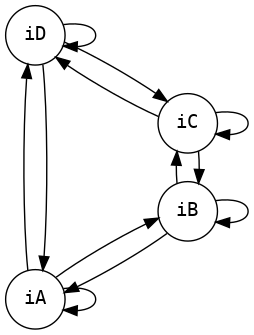

In [5]:
# making a grid 
LAYER_SIZE = 4

temp = 0.4
field = 0
grid_labels = 'ABCDEFGH'

base_params = Params({
    "name": "grid",
    # TODO input layer
    "layers": [
        {
            "layer_name": "input",
            "layer": 0,
            "size": LAYER_SIZE,
            'w_self': 1.0, # 0.8
            'w_input': 0.2, # 0.7
            "k_input": 0,
            'w_lateral': 0.01, # 0.2
            "k_lateral": 1,
            "w_feedback": 0,
            "k_feedback": 0,
            "periodic": True,
            "type": "ising",
            "temp": temp,
            "field": field,
            "labels": ['i' + l for l in grid_labels[:LAYER_SIZE]],
        },
    ]
})

params = deepcopy(base_params)

network = Model(base_params)
network.draw(scale=0.8)

In [6]:
initial_state = 0
timesteps = 5
rng = None
network_states = simulate(pyphi.convert.sbn2sbs(tpm), initial_state, timesteps)
network_states = [(0,)*LAYER_SIZE]*timesteps

transitions = [
    pyphi.actual.Transition(
        network,
        network_state_1,
        network_state_2,
        network.node_indices,
        network.node_indices,
    )
    for network_state_1, network_state_2 in zip(network_states[:-1], network_states[1:])
]

In [7]:
source_nodes = network.node_indices
sink_nodes = network.node_indices
max_purview_size = 5
max_mechainsm_size = 5
all_source_subsets = True
all_sink_subsets = True

transitions = [
    pyphi.actual.Transition(
        network,
        network_state_1,
        network_state_2,
        network.node_indices,
        network.node_indices,
    )
    for network_state_1, network_state_2 in zip(
        network_states[:-1], network_states[1:]
    )
]

effects = cc.get_effects_from_source(
    transitions,
    source_nodes=source_nodes,
    max_purview_size=max_purview_size,
    max_mechanism_size=max_mechainsm_size,
)

causes = cc.get_causes_of_sink(
    transitions,
    sink_nodes=sink_nodes,
    max_purview_size=max_purview_size,
    max_mechanism_size=max_mechainsm_size,
)

cause_chains = cc.get_cause_chains(
    causes,
    len(transitions),
    source_nodes,
    sink_nodes,
    all_source_subsets=all_source_subsets,
    all_sink_subsets=all_sink_subsets,
)

effect_chains = cc.get_effect_chains(
    effects,
    0,
    source_nodes,
    sink_nodes,
    all_source_subsets=all_source_subsets,
    all_sink_subsets=all_sink_subsets,
)

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/50625 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/50625 [00:00<?, ?it/s]

In [8]:
all_subs = list(pyphi.utils.powerset(network.node_indices, nonempty=True))

account_irreducibility = {
    (source, sink): get_process_account(
        cause_chains, effect_chains, source, sink
    )
    for source, sink in tqdm(product(
        all_subs,
        all_subs,
    ),total=len(all_subs)**2)
}

  0%|          | 0/225 [00:00<?, ?it/s]

In [9]:
irreducible_processes = {endpoints: process for endpoints, process in account_irreducibility.items() if process['irreducibility']>0}

In [10]:
len(irreducible_processes) / len(account_irreducibility) 

0.7333333333333333

In [23]:
irreducibilites = {endpoints: process['irreducibility'] for endpoints, process in account_irreducibility.items()}

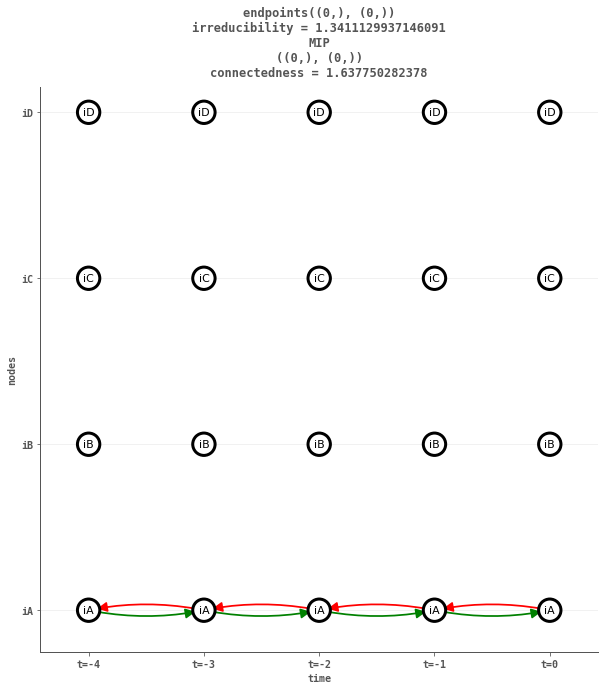

In [24]:
endpoints = max(irreducibilites, key=irreducibilites.get)
process = irreducible_processes[endpoints]
cc.draw_connectedness(
    network,
    (),
    (0, 1, 2, 3),
    network_states,
    get_process_account(cause_chains, effect_chains, endpoints[0], endpoints[1], return_process=True),
    title_prefix="endpoints{}\nirreducibility = {}\nMIP\n{}\n".format(
        endpoints, process["irreducibility"], process["MIP"],
    ),
)

In [27]:
# get all process accounts starting from a specific source
source = (0,1,2, 3)
process_accounts_from_source = {
    endpoints[1]: process
    for endpoints, process in account_irreducibility.items()
    if (process["irreducibility"] > 0 and endpoints[0] == source)
}

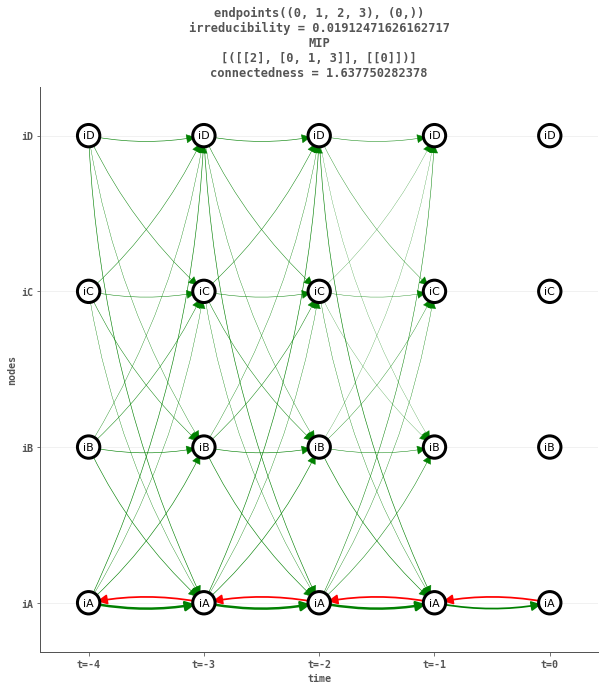

In [28]:
irreducibilites = {
    endpoints: process["irreducibility"]
    for endpoints, process in process_accounts_from_source.items()
}
sink = max(irreducibilites, key=irreducibilites.get) if len(irreducibilites)>0 else ()
cc.draw_connectedness(
    network,
    (),
    (0, 1, 2, 3),
    network_states,
    get_process_account(cause_chains, effect_chains, source, sink, return_process=True),
    title_prefix="endpoints{}\nirreducibility = {}\nMIP\n{}\n".format(
        (source, sink),
        process_accounts_from_source[sink]["irreducibility"],
        process_accounts_from_source[sink]["MIP"],
    ),
)

In [436]:
irreducible_process_list = [
    [
        endpoints[0],
        endpoints[1],
        process["selectivity"].round(4),
        process["informativeness"].round(4),
        process["connectedness"].round(4),
        process["irreducibility"].round(4),
    ]
    for endpoints, process in account_irreducibility.items()
    if process["irreducibility"] > 0
]

In [437]:
irreducible_process_list

[[(0,), (0,), 0.8189, 1.6378, 1.6378, 1.3411],
 [(0,), (0, 1), 0.728, 0.0007, 1.6378, 0.0005],
 [(0,), (0, 4), 0.728, 0.0007, 1.6378, 0.0005],
 [(0,), (1, 4), 0.4099, 0.0025, 0.0025, 0.001],
 [(0,), (0, 1, 4), 0.5463, 0.0039, 1.6378, 0.0022],
 [(0,), (0, 2, 3), 0.5959, 0.0013, 1.6378, 0.0008],
 [(0,), (1, 2, 4), 0.3076, 0.0013, 0.0038, 0.0004],
 [(0,), (1, 3, 4), 0.3076, 0.0013, 0.0038, 0.0004],
 [(0,), (0, 1, 2, 3), 0.4098, 0.0014, 1.6378, 0.0006],
 [(0,), (0, 1, 2, 4), 0.3281, 0.0019, 1.6378, 0.0006],
 [(0,), (0, 1, 3, 4), 0.3281, 0.0019, 1.6378, 0.0006],
 [(0,), (0, 2, 3, 4), 0.4098, 0.0014, 1.6378, 0.0006],
 [(0,), (1, 2, 3, 4), 0.1759, 0.0019, 0.0057, 0.0003],
 [(0,), (0, 1, 2, 3, 4), 0.1603, 0.0058, 1.6378, 0.0009],
 [(1,), (1,), 0.8189, 1.6378, 1.6378, 1.3411],
 [(1,), (0, 2), 0.4099, 0.0025, 0.0025, 0.001],
 [(1,), (1, 2), 0.728, 0.0007, 1.6378, 0.0005],
 [(1,), (0, 1, 2), 0.5959, 0.0032, 1.6378, 0.0019],
 [(1,), (0, 2, 3), 0.3076, 0.0013, 0.0038, 0.0004],
 [(1,), (0, 2, 4), 0.

In [354]:
get_process_account(cause_chains, effect_chains, source, sink, return_process=True)

{'causes': [[((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)]],
 'effects': [[((0, 1), (0, 1), 0.004687552034),
   ((0, 4), (0, 4), 0.004687552034),
   ((0, 2, 4), (0, 1, 3, 4), 0.00218695909),
   ((0, 1, 3, 4), (0, 1, 3, 4), 0.003940233566),
   ((1, 2, 4), (0, 1, 2, 3), 0.00218695909),
   ((1, 2, 3, 4), (1, 2, 3, 4), 0.003940233566),
   ((0, 1, 2, 3), (0, 1, 2, 3), 0.003940233566),
   ((0,), (0,), 0.818875141189),
   ((0, 1, 2, 3, 4), (0, 1, 2, 3, 4), 0.007336831175),
   ((0, 2, 3), (1, 2, 3, 4), 0.00218695909),
   ((0, 1, 2), (0, 1, 2), 0.004297971341),
   ((0, 1, 3), (0, 1, 2, 4), 0.00218695909),
   ((0, 1, 2, 4), (0, 1, 2, 4), 0.003940233566),
   ((0, 3, 4), (0, 3, 4), 0.004297971341),
   ((1, 4), (0,), 0.002533480295),
   ((1, 3, 4), (0, 2, 3, 4), 0.00218695909),
   ((0, 1, 4), (0, 1, 4), 0.004297971341),
   ((0, 2, 3, 4), (0, 2, 3, 4), 0.003940233566)],
  [((0, 1), (0, 1), 0.004687552034),
   ((0, 

In [111]:
core = (1,2)

effs = cc.get_bundled_chains(filter_core_chains(effect_chains, core, 2, chain_type='effect'))
caus = cc.get_bundled_chains(filter_core_chains(cause_chains, core, 2, chain_type='cause'))

# then, we compute the subprocess' connectedness by summing the bundle strength of the remaining cause and effect chains.
connectedness = sum([cc.get_bundle_strength(effs), cc.get_bundle_strength(caus)])

# finally, we return the process with its causal bundles and its total connectedness
process = {
    "causes": caus,
    "effects": effs,
    "connectedness": connectedness,
}


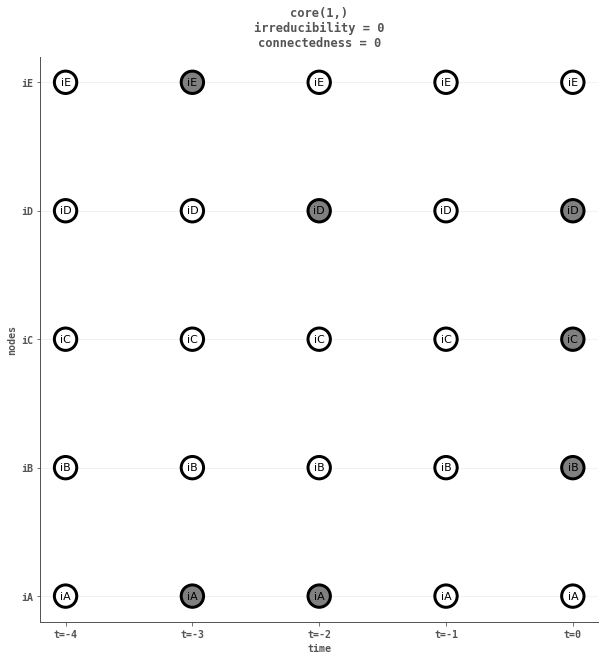

In [110]:
cc.draw_connectedness(
    network,
    (),
    (0, 1, 2, 3, 4),
    network_states,
    process,
    title_prefix="core{}\nirreducibility = {}\n".format(
        core, process["connectedness"],
    ),
)

In [112]:
process = get_process_account(cause_chains, effect_chains, source, sink, return_process=True)
process

{'causes': [[((4,), (4,), 0.818875141189)],
  [((4,), (4,), 0.818875141189)],
  [((4,), (3,), 0.002533495749)],
  [((3,), (3,), 0.818875141189)]],
 'effects': [[((2, 4), (3,), 0.002533480295),
   ((2, 3), (2, 3), 0.004687552034),
   ((3, 4), (3,), 0.002531464716),
   ((2, 3, 4), (3,), 0.002477736829),
   ((3,), (3,), 0.818875141189),
   ((4,), (3,), 0.002533495749)],
  [((3,), (2, 4), 0.002542378266)],
  [((2, 4), (3,), 0.002533480295), ((4,), (4,), 0.818875141189)],
  [((3,), (4,), 0.002533495749), ((4,), (4,), 0.818875141189)]],
 'connectedness': 0.005075874015}

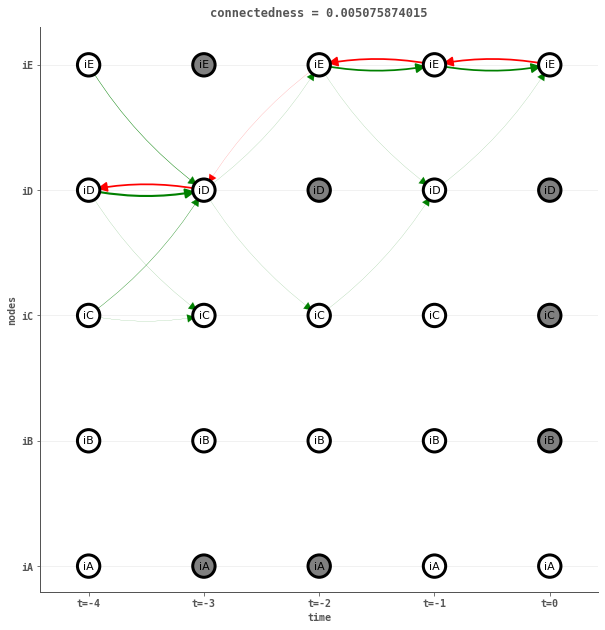

In [113]:
cc.draw_connectedness(
    network,
    (),
    (0, 1, 2, 3, 4),
    network_states,
    process,
)

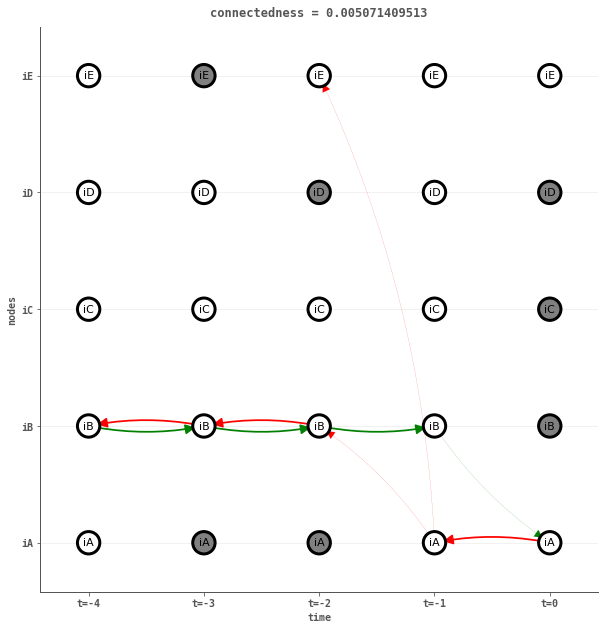

In [115]:
source = (1,)#network.node_indices
sink = (0,)#network.node_indices

cc.draw_connectedness(
    network,
    (),
    (0, 1, 2, 3, 4),
    network_states,
    get_subprocess(cause_chains, effect_chains, (source, sink)),
)

  0%|          | 0/961 [00:00<?, ?it/s]

In [53]:
get_process_irreducibility(
        cause_chains, effect_chains, (0,), (0,1))

{'source': (0,),
 'sink': (0, 1),
 'connectedness': 1.63783684422,
 'irreducibility': 0.0,
 'MIP': (((0,),), ((0,), (1,)))}

In [51]:
irreducible_processes = {key: process for key, process in irreducibility.items() if process['irreducibility']>0}

In [52]:
irreducible_processes

{((0,), (0,)): {'source': (0,),
  'sink': (0,),
  'connectedness': 1.63783684422,
  'irreducibility': 1.63783684422,
  'MIP': (((0,),), ((0,),))},
 ((0,), (0, 1, 2, 3)): {'source': (0,),
  'sink': (0, 1, 2, 3),
  'connectedness': 1.63783684422,
  'irreducibility': 0.000646159323,
  'MIP': (((0,),), ((0, 1, 2), (3,)))},
 ((1,), (1,)): {'source': (1,),
  'sink': (1,),
  'connectedness': 1.637750282378,
  'irreducibility': 1.637750282378,
  'MIP': (((1,),), ((1,),))},
 ((1,), (0, 1)): {'source': (1,),
  'sink': (0, 1),
  'connectedness': 1.637750282378,
  'irreducibility': 0.000707463264,
  'MIP': (((1,),), ((0,), (1,)))},
 ((1,), (0, 2)): {'source': (1,),
  'sink': (0, 2),
  'connectedness': 0.002532958596,
  'irreducibility': 0.002532958596,
  'MIP': (((1,),), ((0,), (2,)))},
 ((1,), (1, 2)): {'source': (1,),
  'sink': (1, 2),
  'connectedness': 1.637750282378,
  'irreducibility': 0.000707590983,
  'MIP': (((1,),), ((1,), (2,)))},
 ((1,), (0, 1, 2)): {'source': (1,),
  'sink': (0, 1, 2)

# Creating the being

In [34]:
# first we need two experiences
system_1 = pyphi.subsystem.Subsystem(network, network_states[0],nodes=network.node_indices)
system_2 = pyphi.subsystem.Subsystem(network, network_states[1],nodes=network.node_indices)

ces_1 = pyphi.compute.ces(system_1)
ces_2 = pyphi.compute.ces(system_2)

In [103]:
def get_unique_causeeffects(links):
    actual_links = []
    for mechanism1, link1 in links.items():
        update_link = True
        for mechanism2, link2 in links.items():
            if (list(link1.keys())[0] == list(link2.keys())[0]) and (
                list(link1.values())[0] < list(link2.values())[0]
            ):
                update_link = False

        if update_link:
            actual_links.append(
                [mechanism1, list(link1.keys())[0], list(link1.values())[0]]
            )

    return [actual_links]


def get_complex_account(ces_1, ces_2):

    transition = pyphi.actual.Transition(
        ces_2.subsystem.network,
        ces_1.subsystem.state,
        ces_2.subsystem.state,
        ces_1.subsystem.node_indices,
        ces_2.subsystem.node_indices,
    )

    mechanisms_1 = list(ces_1.mechanisms)
    mechanisms_2 = list(ces_2.mechanisms)

    # get all actual causes
    causes = get_unique_causeeffects(
            {
                mechanism: {
                    link.purview: link.alpha
                    for link in (
                        transition.find_actual_cause(mechanism, purviews=mechanisms_2),
                    )
                }
                for mechanism in mechanisms_1
            }
        )
    
    effects = get_unique_causeeffects(
            {
                mechanism: {
                    link.purview: link.alpha
                    for link in (
                        transition.find_actual_effect(mechanism, purviews=mechanisms_1),
                    )
                }
                for mechanism in mechanisms_2
            }
        )
    
    cause_chains = cc.get_cause_chains(
        causes,
        1,
        ces_1.subsystem.node_indices,
        ces_2.subsystem.node_indices,
        all_source_subsets=True,
        all_sink_subsets=True,
    )

    effect_chains = cc.get_effect_chains(
        effects,
        0,
        ces_1.subsystem.node_indices, 
        ces_2.subsystem.node_indices,
        all_source_subsets=True,
        all_sink_subsets=True,
        time_restricted_source=False,
    )
    
    return get_process_account(
        cause_chains, effect_chains, ces_1.subsystem.node_indices, ces_2.subsystem.node_indices
    )

In [104]:
get_complex_account(ces_1, ces_2)

Computing cause chains:   0%|          | 0/15 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

{'process': {'causes': [[((1, 3, 4), (0, 2), 0.00127111107),
    ((0, 1, 2, 4), (0, 2, 3), 0.000646314765),
    ((0, 2, 4), (1, 3), 0.00127111107),
    ((0, 2, 3, 4), (0, 1, 3), 0.000646314765),
    ((1,), (1,), 0.818875141189),
    ((0,), (0,), 0.818875141189),
    ((0, 1, 3), (2, 4), 0.00127111107),
    ((3,), (3,), 0.818875141189),
    ((0, 1, 3, 4), (0, 2, 3), 0.000646314765),
    ((2,), (2,), 0.818875141189),
    ((0, 1, 2, 3), (0, 2, 4), 0.000646314765),
    ((0, 2, 3), (1, 4), 0.00127111107),
    ((1, 2, 3, 4), (0, 1, 3), 0.000646314765),
    ((1, 2, 4), (0, 3), 0.00127111107),
    ((4,), (4,), 0.818875141189)]],
  'effects': [[((0, 1), (0, 1), 0.004687552034),
    ((0, 1, 3, 4), (0, 1, 3, 4), 0.003940233566),
    ((1, 2, 3), (1, 2, 3), 0.004297971341),
    ((1, 2, 3, 4), (1, 2, 3, 4), 0.003940233566),
    ((0, 1, 2, 3), (0, 1, 2, 3), 0.003940233566),
    ((2, 3, 4), (2, 3, 4), 0.004297971341),
    ((0, 1, 4), (0, 1, 4), 0.004297971341),
    ((2,), (2,), 0.818875141189),
    ((3

In [246]:
cc.get_effect_chains(
    get_unique_causeeffects(effects),
    0,
    (0, 1, 2, 3, 4), 
    (0, 1, 2, 3, 4),
    all_source_subsets=True,
    all_sink_subsets=True,
    time_restricted_source=False,
)

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

[[((0,), (0,), 0.818875141189)],
 [((1,), (1,), 0.818875141189)],
 [((2,), (2,), 0.818875141189)],
 [((3,), (3,), 0.818875141189)],
 [((4,), (4,), 0.818875141189)],
 [((0, 1), (0, 1), 0.004687552034)],
 [((0, 4), (0, 4), 0.004687552034)],
 [((1, 2), (1, 2), 0.004687552034)],
 [((2, 3), (2, 3), 0.004687552034)],
 [((3, 4), (3, 4), 0.004687552034)],
 [((0, 1, 2), (0, 1, 2), 0.004297971341)],
 [((0, 1, 4), (0, 1, 4), 0.004297971341)],
 [((0, 3, 4), (0, 3, 4), 0.004297971341)],
 [((1, 2, 3), (1, 2, 3), 0.004297971341)],
 [((2, 3, 4), (2, 3, 4), 0.004297971341)],
 [((0, 1, 2, 3), (0, 1, 2, 3), 0.003940233566)],
 [((0, 1, 2, 4), (0, 1, 2, 4), 0.003940233566)],
 [((0, 1, 3, 4), (0, 1, 3, 4), 0.003940233566)],
 [((0, 2, 3, 4), (0, 2, 3, 4), 0.003940233566)],
 [((1, 2, 3, 4), (1, 2, 3, 4), 0.003940233566)],
 [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4), 0.007336831175)]]

[[(0,), (0,), 0.818875141189],
 [(1,), (1,), 0.818875141189],
 [(2,), (2,), 0.818875141189],
 [(3,), (3,), 0.818875141189],
 [(4,), (4,), 0.818875141189],
 [(0, 1), (0, 1), 0.004687552034],
 [(0, 4), (0, 4), 0.004687552034],
 [(1, 2), (1, 2), 0.004687552034],
 [(2, 3), (2, 3), 0.004687552034],
 [(3, 4), (3, 4), 0.004687552034],
 [(0, 1, 2), (0, 1, 2), 0.004297971341],
 [(0, 1, 4), (0, 1, 4), 0.004297971341],
 [(0, 3, 4), (0, 3, 4), 0.004297971341],
 [(1, 2, 3), (1, 2, 3), 0.004297971341],
 [(2, 3, 4), (2, 3, 4), 0.004297971341],
 [(0, 1, 2, 3), (0, 1, 2, 3), 0.003940233566],
 [(0, 1, 2, 4), (0, 1, 2, 4), 0.003940233566],
 [(0, 1, 3, 4), (0, 1, 3, 4), 0.003940233566],
 [(0, 2, 3, 4), (0, 2, 3, 4), 0.003940233566],
 [(1, 2, 3, 4), (1, 2, 3, 4), 0.003940233566],
 [(0, 1, 2, 3, 4), (0, 1, 2, 3, 4), 0.007336831175]]

In [85]:
effects

{(0,): {(0,): 0.818875141189},
 (1,): {(1,): 0.818875141189},
 (2,): {(2,): 0.818875141189},
 (3,): {(3,): 0.818875141189},
 (4,): {(4,): 0.818875141189},
 (0, 1): {(0, 1): 0.004687552034},
 (0, 2): {(1,): 0.002533480295},
 (0, 3): {(4,): 0.002533480295},
 (0, 4): {(0, 4): 0.004687552034},
 (1, 2): {(1, 2): 0.004687552034},
 (1, 3): {(2,): 0.002533480295},
 (1, 4): {(0,): 0.002533480295},
 (2, 3): {(2, 3): 0.004687552034},
 (2, 4): {(3,): 0.002533480295},
 (3, 4): {(3, 4): 0.004687552034},
 (0, 1, 2): {(0, 1, 2): 0.004297971341},
 (0, 1, 3): {(0, 1, 2, 4): 0.00218695909},
 (0, 1, 4): {(0, 1, 4): 0.004297971341},
 (0, 2, 3): {(1, 2, 3, 4): 0.00218695909},
 (0, 2, 4): {(0, 1, 3, 4): 0.00218695909},
 (0, 3, 4): {(0, 3, 4): 0.004297971341},
 (1, 2, 3): {(1, 2, 3): 0.004297971341},
 (1, 2, 4): {(0, 1, 2, 3): 0.00218695909},
 (1, 3, 4): {(0, 2, 3, 4): 0.00218695909},
 (2, 3, 4): {(2, 3, 4): 0.004297971341},
 (0, 1, 2, 3): {(0, 1, 2, 3): 0.003940233566},
 (0, 1, 2, 4): {(0, 1, 2, 4): 0.003940

In [83]:
effects)

[[(0,), (0,), 0.818875141189],
 [(1,), (1,), 0.818875141189],
 [(2,), (2,), 0.818875141189],
 [(3,), (3,), 0.818875141189],
 [(4,), (4,), 0.818875141189],
 [(0, 1), (0, 1), 0.004687552034],
 [(0, 4), (0, 4), 0.004687552034],
 [(1, 2), (1, 2), 0.004687552034],
 [(2, 3), (2, 3), 0.004687552034],
 [(3, 4), (3, 4), 0.004687552034],
 [(0, 1, 2), (0, 1, 2), 0.004297971341],
 [(0, 1, 4), (0, 1, 4), 0.004297971341],
 [(0, 3, 4), (0, 3, 4), 0.004297971341],
 [(1, 2, 3), (1, 2, 3), 0.004297971341],
 [(2, 3, 4), (2, 3, 4), 0.004297971341],
 [(0, 1, 2, 3), (0, 1, 2, 3), 0.003940233566],
 [(0, 1, 2, 4), (0, 1, 2, 4), 0.003940233566],
 [(0, 1, 3, 4), (0, 1, 3, 4), 0.003940233566],
 [(0, 2, 3, 4), (0, 2, 3, 4), 0.003940233566],
 [(1, 2, 3, 4), (1, 2, 3, 4), 0.003940233566],
 [(0, 1, 2, 3, 4), (0, 1, 2, 3, 4), 0.007336831175]]

In [65]:
actual_links = dict()
for purview1, link1 in causes.items():
    update_link = True
    for purview2, link2 in causes.items():
        if (list(link1.keys())[0] == list(link2.keys())[0]) and (
            list(link1.values())[0] < list(link2.values())[0]
        ):
            update_link = False

    if update_link:
        actual_links.update(link1)

In [66]:
actual_links

{(0,): 0.818875141189,
 (1,): 0.818875141189,
 (2,): 0.818875141189,
 (3,): 0.818875141189,
 (4,): 0.818875141189,
 (2, 4): 0.00127111107,
 (1, 4): 0.00127111107,
 (1, 3): 0.00127111107,
 (0, 3): 0.00127111107,
 (0, 2): 0.00127111107,
 (0, 2, 4): 0.000646314765,
 (0, 2, 3): 0.000646314765,
 (0, 1, 3): 0.000646314765}

In [142]:
get_process_irreducibility(
    cause_chains, effect_chains, (0,1,2,3), (0,1,2,3), k=3, only_subsets=True
)

{'source': (0, 1, 2, 3),
 'sink': (0, 1, 2, 3),
 'connectedness': 6.587040840632,
 'irreducibility': 0.03603971111999993,
 'MIP': ([[0, 1], [2, 3]], [[1, 2], [0, 3]])}

In [143]:
get_process_irreducibility(
    cause_chains, effect_chains, (0,1,2,3), (0,1,2,3), k=3, only_subsets=False
)

{'source': (0, 1, 2, 3),
 'sink': (0, 1, 2, 3),
 'connectedness': 6.587040840632,
 'irreducibility': 0.0,
 'MIP': ([[2], [0, 1, 3]], [[2], [0, 1, 3]])}

In [235]:
all_subs = list(pyphi.utils.powerset(network.node_indices, nonempty=True))

account_irreducibility_T = {
    (source, sink): get_process_irreducibility(
        cause_chains, effect_chains, source, sink, only_subsets=True
    )
    for source, sink in tqdm(product(
        all_subs,
        all_subs,
    ),total=len(all_subs)**2)
}

  0%|          | 0/961 [00:00<?, ?it/s]

In [236]:
irreducible_processes_T = {endpoints: process for endpoints, process in account_irreducibility_T.items() if process['irreducibility']>0}

In [237]:
all_subs = list(pyphi.utils.powerset(network.node_indices, nonempty=True))

account_irreducibility_F = {
    (source, sink): get_process_irreducibility(
        cause_chains, effect_chains, source, sink, only_subsets=False
    )
    for source, sink in tqdm(product(
        all_subs,
        all_subs,
    ),total=len(all_subs)**2)
}

  0%|          | 0/961 [00:00<?, ?it/s]

In [238]:
irreducible_processes_F = {endpoints: process for endpoints, process in account_irreducibility_F.items() if process['irreducibility']>0}

In [239]:
subsets = irreducible_processes_T.keys()
parts = irreducible_processes_F.keys()
only_subsets = [k for k in subsets if k not in parts]
only_parts = [k for k in parts if k not in subsets]

In [240]:
irreducible_processes_T[only_subsets[0]]

{'source': (0, 1),
 'sink': (0, 2),
 'connectedness': 1.640283700281,
 'irreducibility': 0.0025334179030001014,
 'MIP': ([[0], [1]], [[0], [2]])}

In [241]:
account_irreducibility_F[only_subsets[0]]

{'source': (0, 1),
 'sink': (0, 2),
 'connectedness': 1.640283700281,
 'irreducibility': 0.0,
 'MIP': ([[0], [1]], [[0], [2]])}

In [242]:
irreducible_processes_F[only_parts[0]]

{'source': (0,),
 'sink': (0, 1),
 'connectedness': 1.637750282378,
 'irreducibility': 0.000707590983,
 'MIP': ([[0]], [[0], [1]])}

In [243]:
account_irreducibility_T[only_parts[0]]

{'source': (0,),
 'sink': (0, 1),
 'connectedness': 1.637750282378,
 'irreducibility': 0.0,
 'MIP': ([[0]], [[0], [1]])}

In [244]:
only_subsets

[((0, 1), (0, 2)),
 ((0, 1), (1, 4)),
 ((0, 1), (0, 1, 2)),
 ((0, 1), (0, 1, 3)),
 ((0, 1), (0, 1, 4)),
 ((0, 1), (0, 2, 4)),
 ((0, 1), (1, 2, 4)),
 ((0, 2), (0, 1)),
 ((0, 2), (1, 2)),
 ((0, 2), (1, 3)),
 ((0, 2), (1, 4)),
 ((0, 2), (0, 1, 2)),
 ((0, 2), (0, 1, 3)),
 ((0, 2), (0, 1, 4)),
 ((0, 2), (1, 2, 3)),
 ((0, 2), (1, 2, 4)),
 ((0, 3), (0, 4)),
 ((0, 3), (1, 4)),
 ((0, 3), (2, 4)),
 ((0, 3), (3, 4)),
 ((0, 3), (0, 1, 4)),
 ((0, 3), (0, 2, 4)),
 ((0, 3), (0, 3, 4)),
 ((0, 3), (1, 3, 4)),
 ((0, 3), (2, 3, 4)),
 ((0, 4), (0, 3)),
 ((0, 4), (1, 4)),
 ((0, 4), (0, 1, 3)),
 ((0, 4), (0, 1, 4)),
 ((0, 4), (0, 2, 4)),
 ((0, 4), (0, 3, 4)),
 ((0, 4), (1, 3, 4)),
 ((1, 2), (0, 2)),
 ((1, 2), (1, 3)),
 ((1, 2), (0, 1, 2)),
 ((1, 2), (0, 1, 3)),
 ((1, 2), (0, 2, 3)),
 ((1, 2), (1, 2, 3)),
 ((1, 2), (1, 2, 4)),
 ((1, 3), (0, 2)),
 ((1, 3), (1, 2)),
 ((1, 3), (2, 3)),
 ((1, 3), (2, 4)),
 ((1, 3), (0, 1, 2)),
 ((1, 3), (0, 2, 3)),
 ((1, 3), (1, 2, 3)),
 ((1, 3), (1, 2, 4)),
 ((1, 3), (2, 3, 4))

In [245]:
only_parts

[((0,), (0, 1)),
 ((0,), (0, 4)),
 ((0,), (0, 1, 4)),
 ((0,), (0, 2, 3)),
 ((0,), (0, 1, 2, 3)),
 ((0,), (0, 1, 2, 4)),
 ((0,), (0, 1, 3, 4)),
 ((0,), (0, 2, 3, 4)),
 ((0,), (0, 1, 2, 3, 4)),
 ((1,), (1, 2)),
 ((1,), (0, 1, 2)),
 ((1,), (1, 3, 4)),
 ((1,), (0, 1, 2, 3)),
 ((1,), (0, 1, 2, 4)),
 ((1,), (0, 1, 3, 4)),
 ((1,), (1, 2, 3, 4)),
 ((1,), (0, 1, 2, 3, 4)),
 ((2,), (2, 3)),
 ((2,), (0, 2, 4)),
 ((2,), (1, 2, 3)),
 ((2,), (0, 1, 2, 3)),
 ((2,), (0, 1, 2, 4)),
 ((2,), (0, 2, 3, 4)),
 ((2,), (1, 2, 3, 4)),
 ((2,), (0, 1, 2, 3, 4)),
 ((3,), (3, 4)),
 ((3,), (0, 1, 3)),
 ((3,), (2, 3, 4)),
 ((3,), (0, 1, 2, 3)),
 ((3,), (0, 1, 3, 4)),
 ((3,), (0, 2, 3, 4)),
 ((3,), (1, 2, 3, 4)),
 ((3,), (0, 1, 2, 3, 4)),
 ((4,), (0, 3, 4)),
 ((4,), (1, 2, 4)),
 ((4,), (0, 1, 2, 4)),
 ((4,), (0, 1, 3, 4)),
 ((4,), (0, 2, 3, 4)),
 ((4,), (1, 2, 3, 4)),
 ((4,), (0, 1, 2, 3, 4)),
 ((0, 1), (0,)),
 ((0, 1), (1,)),
 ((0, 2), (0, 2, 3, 4)),
 ((0, 3), (0, 1, 2, 3)),
 ((0, 4), (0,)),
 ((0, 4), (4,)),
 ((1, 2

In [183]:
print([len(p) for p in list(pyphi.partition.partition_types['k_partition_nonempty']((1,2,3,4), 4))])

[1, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 4]


In [278]:
get_process_irreducibility(
    cause_chains, effect_chains, (0,1), (0,1), k=3, only_subsets=False
)

{'source': (0, 1),
 'sink': (0, 1),
 'connectedness': 3.2801881167899998,
 'irreducibility': 0.004687552034,
 'MIP': ([[0], [1]], [[0], [1]])}

In [279]:
get_process_irreducibility(
    cause_chains, effect_chains, (0,1), (0,1), k=3, only_subsets=True
)

{'source': (0, 1),
 'sink': (0, 1),
 'connectedness': 3.2801881167899998,
 'irreducibility': 0,
 'MIP': ([[0, 1]], [[0], [1]])}

In [272]:
source = (1,2)
sink = (2,3)

connectedness = get_subprocess(cause_chains, effect_chains, (source, sink))[
        "connectedness"
    ]

irreducibility = np.inf
MIP = (source, sink)
k = max([len(source), len(sink)])


for source_partition, sink_partition in product(
    list(pyphi.partition.partition_types['k_partition_nonempty'](source, k)), #
    list(pyphi.partition.partition_types['k_partition_nonempty'](sink, k)), #
):
    if (len(source_partition)>1 or len(sink_partition)>1):
        part_cause_chains = []
        part_effect_chains = []
        for source_part, sink_part in product(source_partition, sink_partition):
            part_cause_chains.extend(filter_cause_chains(cause_chains, (source_part, sink_part)))
            part_effect_chains.extend(filter_effect_chains(effect_chains, (source_part, sink_part)))

        # then, we compute the subprocess' connectedness by summing the bundle strength of the remaining cause and effect chains.
        part_connectedness = sum(
            [cc.get_bundle_strength(cc.get_bundled_chains(part_cause_chains)), cc.get_bundle_strength(cc.get_bundled_chains(part_effect_chains))]
        )
        
        if connectedness-part_connectedness < irreducibility:
            irreducibility = 0
            MIP = (source_partition, sink_partition)
            

In [268]:
connectedness

1.637750282378

In [264]:
filter_cause_chains(cause_chains, (source_part, sink_part))

[]

In [280]:
source = (1,2)
sink = (1,2)
process = get_subprocess(cause_chains, effect_chains, (source, sink))

[[((2,), (2,), 0.818875141189),
  ((1, 2), (1,), 0.000707590983),
  ((1,), (1,), 0.818875141189)],
 [((2,), (2,), 0.818875141189), ((1,), (1,), 0.818875141189)],
 [((2,), (2,), 0.818875141189), ((1,), (1,), 0.818875141189)],
 [((2,), (2,), 0.818875141189), ((1,), (1,), 0.818875141189)]]

In [300]:
get_process_account(
    cause_chains,
    effect_chains,
    (0,1,2,3),
    (0,1,2,3),
    hold_process=True
)

{'process': 'hidden',
 'source': (0, 1, 2, 3),
 'sink': (0, 1, 2, 3),
 'connectedness': 26.462077803073996,
 'informativeness': 4.224756493684,
 'selectivity': 0.8269399313460624,
 'irreducibility': 3.493619844840878,
 'MIP': ([[0, 1, 2], [3]], [[0], [1, 2, 3]])}

In [334]:
get_process_account(
    cause_chains,
    effect_chains,
    (0,),
    (0,),
    hold_process=True
)

{'process': 'hidden',
 'source': (0,),
 'sink': (0,),
 'connectedness': 1.637750282378,
 'informativeness': 1.637750282378,
 'selectivity': 0.20471878529725,
 'irreducibility': 0.3352782484286523,
 'MIP': ((0,), (0,))}

In [317]:
get_bundle_informativeness(
    cause_chains, effect_chains, (0,), (0,), process=None
)

6.551001129512

In [320]:
process = get_subprocess(cause_chains, effect_chains, ((0,), (0,)))

In [321]:
process

{'causes': [[((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)]],
 'effects': [[((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)],
  [((0,), (0,), 0.818875141189)]],
 'connectedness': 6.551001129512}

In [322]:
get_bundle_informativeness(
    cause_chains, effect_chains, (0,), (0,), process=process
)

6.551001129512